<a href="https://colab.research.google.com/github/lucascarter0/data-science-tools/blob/master/preliminary_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pymc3==3.8
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import pandas as pd


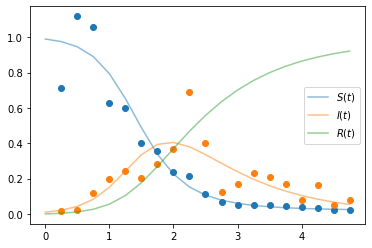

In [0]:
def SIR(y, t, p):
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    return [ds, di]
    
times = np.arange(0,5,0.25)

beta,gamma = 4,1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta,gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])


plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, (1-y[:,0]-y[:,1]), color='C2', alpha=0.5, label=f'$R(t)$')
plt.legend()
plt.show()

In [0]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2,3)
    lam = pm.Lognormal('lambda',pm.math.log(2),2)
    beta = pm.Deterministic('beta', lam*R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs)

  prior = pm.sample_prior_predictive()
  trace = pm.sample(1000,tune=500, target_accept=0.9, cores=1)
  posterior_predictive = pm.sample_posterior_predictive(trace)

  data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda, R0, sigma]
Sampling chain 0, 0 divergences:  92%|█████████▏| 1374/1500 [10:11<00:42,  2.98it/s]

In [0]:
from datetime import timedelta, date
import os

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

df = pd.DataFrame(columns=['Confirmed','Deaths','Recovered','Active'])
start_date = date(2020, 3, 22)
end_date = date(2020, 5, 2)
for single_date in daterange(start_date, end_date):
    date = single_date.strftime('%m-%d-%Y')
    basepath = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports'
    url = os.path.join(basepath, '{}.csv'.format(date))

    a = pd.read_csv(url, index_col=-1, usecols=['Confirmed','Deaths','Recovered','Active', 'Combined_Key'])

    try:
      df.loc[single_date] = a.loc['Dallas, Texas, US']
    except KeyError:
      continue

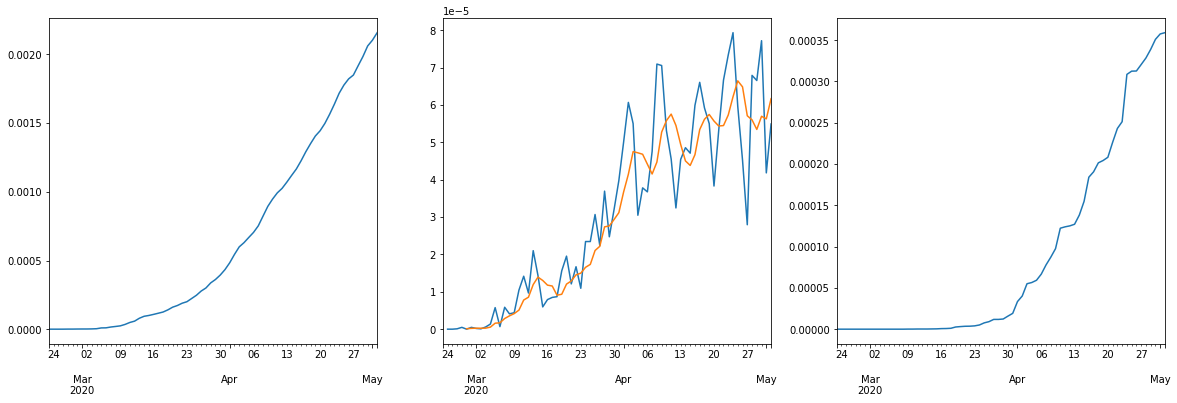

In [142]:
%matplotlib inline

country = 'Sweden'
population = 10230200
start_date = '2020-2-23'

def get_JHU_series(url, country, start_date, name=''):
  df = pd.read_csv(url, index_col=1)
  df = df.loc[country]
  df = df.drop(['Province/State','Lat', 'Long'])

  df.index = pd.to_datetime(df.index)
  df = df.loc[start_date:]
  df.name = name

  return df

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
infected = get_JHU_series(url, country='Sweden', start_date='2020-2-23', name='Infected')
infected = infected / population

new_cases = infected.diff()
new_cases.name = 'New Cases'


url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recovered = get_JHU_series(url, country='Sweden', start_date='2020-2-23', name='Removed')

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = get_JHU_series(url, country='Sweden', start_date='2020-2-23', name='Deaths')

removed = (recovered + deaths) / population
susceptible = (1- infected - removed)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
infected.plot(ax=ax[0])
new_cases.plot(ax=ax[1])
new_cases.rolling(window=5).mean().plot(ax=ax[1], label='Smoothed Daily Cases')
removed.plot(ax=ax[2], label='Removed Cases')


In [0]:
def SIR(y, t, p):
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    dr = p[1]*y[1]
    return [ds, di, dr]


sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=3,
    n_theta=2,
    t0=0,
)

times = np.arange(0,5,0.25)

In [143]:
with pm.Model() as model:

  theta0I = pm.Beta('theta0I', 1, 10)
  theta0S = pm.Beta('theta0S', 1, 10)
  theta0R = 1 - theta0S - theta0I

  R0 = pm.Lognormal('R0', mu=3.15, sigma=1)
  gamma = pm.Lognormal('gamma', mu=0.0117, sigma=0.1)
  beta = pm.Deterministic('beta', gamma*R0)

  kappa = pm.Gamma('kappa', 2, 0.0001)

  f = sir_model(y0=[theta0S, theta0I, theta0R], theta=[beta, gamma])
  theta = pm.Dirichlet('theta', kappa*f, observed=[susceptible, infected, removed])

  #lambdaI = pm.Gamma('lambdaI', 2, 0.0001)
  #lambdaR = pm.Gamma('labmdaR', 2, 0.0001)

  #YI = pm.Beta('YI', alpha=lambdaI*theta[1], beta=lambdaI*(1 - theta[1]), observed=yobs[:,1])

TypeError: ignored